# Reconstructed autoencoder

In [1]:
## load the libraries 
import tensorflow as tf
from tensorflow import keras
from keras import  Model, models, layers, optimizers, regularizers
from keras.layers import Dense, Input, LSTM, Dropout, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.metrics import *
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import metrics
from pylab import rcParams
from collections import Counter
from itertools import repeat
from time import perf_counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import os

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
pd.set_option('display.max_columns', None)
tf.keras.backend.set_floatx('float32')
os.getcwd()

'/content'

In [2]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }
def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/'
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

In [3]:
def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [4]:
def preprocessing():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)
    
    # 데이터 유형별 분류하기
    data = reorganization(df)
    modified_df = pd.DataFrame()

    for i, c in enumerate(data.columns):
        if c in cols['obj']:
            obj_data = pd.get_dummies(data[c], prefix=c, prefix_sep = "/")
            modified_df = pd.concat([modified_df, obj_data], axis=1)

        elif c in cols['cat']:  # click_label 컬럼 = y 변수로 사용
            if 'click' in c:
                pass
            else:
                cat_data = pd.get_dummies(data[c], prefix=c, prefix_sep = "/")
                modified_df = pd.concat([modified_df, cat_data], axis=1)
        else:
            scaled_num_data = MinMaxScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)
            
    print('---- Data info ----')
    print(cols)
    print('Data Frame shape: {}'.format(modified_df.shape))
    
    return modified_df

In [5]:
# 데이터 7:3으로 나누기 (검증 데이터는 8:2)
def split_data():

  ### read dataset 
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    modified_df = preprocessing()

    X = modified_df
    y = df['click_label']

    # split the train/test data (7:3 ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기
    print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
    print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')
    
    oversample = SMOTE(random_state=2022) # 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    ## create train and validation datasets (8:2 ratio)
    x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify = y_train)
    print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
    print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
   
    ## reshape the inputs
    x_train = x_train.values.reshape(-1, x_train.shape[1])
    x_val = x_val.values.reshape(-1, x_val.shape[1])

    return x_train, X_test, x_val, y_train, y_test, y_val

x_train, X_test, x_val, y_train, y_test, y_val = split_data()

---- Data info ----
{'obj': ['user_gender'], 'cat': ['imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt'], 'cont': ['user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']}
Data Frame shape: (842463, 101)
# of train_data's rows: 589724 
# of test_data's rows: 252739
train:test ratio = 0.7:0.3
# of train_data's rows: 915880 
# of validation_data's rows: 228970
train:test ratio = 0.8:0.2


In [6]:
# Stacked autoencoder code
## input layer
input_layer = Input(shape=(x_train.shape[1],))
print(f"input layer's shape: {input_layer.shape}")

## encoding architecture
encode_layer = Dense(150, activation='relu', activity_regularizer = 'l2')(input_layer)

## latent view
latent_view  = Dense(10, activation='sigmoid')(encode_layer)

## decoding architecture
decode_layer = Dense(150, activation='relu', activity_regularizer = 'l2')(latent_view)

## output layer
output_layer = Dense(x_train.shape[1],)(decode_layer)
print(f"output layer's shape: {output_layer.shape}")

# layer_loss = tf.losses.binary_crossentropy(input_layer, output_layer)
# print(f"binary_crossentropy of Autoencoder model: {layer_loss}")

model = tf.keras.Model(input_layer, output_layer)
print(model.summary())

input layer's shape: (None, 101)
output layer's shape: (None, 101)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 101)]             0         
                                                                 
 dense (Dense)               (None, 150)               15300     
                                                                 
 dense_1 (Dense)             (None, 10)                1510      
                                                                 
 dense_2 (Dense)             (None, 150)               1650      
                                                                 
 dense_3 (Dense)             (None, 101)               15251     
                                                                 
Total params: 33,711
Trainable params: 33,711
Non-trainable params: 0
________________________________________________________

In [7]:
# patience: patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto') 
start = perf_counter()
history = model.fit(x_train, y_train, epochs=200, batch_size=512, validation_data=(x_val, y_val), callbacks=[early_stopping])
print("End of Training")
print("걸린 시간: {:g}분 {:.2f}초".format((perf_counter() - start)//60, round((perf_counter() - start)%60)))

Epoch 1/200
1789/1789 [==============================] - 20s 11ms/step - loss: 1.4868 - binary_accuracy: 0.7017 - val_loss: 1.3291 - val_binary_accuracy: 0.7299
Epoch 2/200
1789/1789 [==============================] - 19s 11ms/step - loss: 1.2911 - binary_accuracy: 0.7356 - val_loss: 1.2401 - val_binary_accuracy: 0.7431
Epoch 3/200
1789/1789 [==============================] - 19s 11ms/step - loss: 1.2477 - binary_accuracy: 0.7434 - val_loss: 1.2362 - val_binary_accuracy: 0.7491
Epoch 4/200
1789/1789 [==============================] - 19s 10ms/step - loss: 1.2320 - binary_accuracy: 0.7519 - val_loss: 1.2267 - val_binary_accuracy: 0.7511
Epoch 5/200
1789/1789 [==============================] - 19s 11ms/step - loss: 1.2315 - binary_accuracy: 0.7518 - val_loss: 1.2309 - val_binary_accuracy: 0.7561
Epoch 6/200
1789/1789 [==============================] - 19s 11ms/step - loss: 1.2250 - binary_accuracy: 0.7565 - val_loss: 1.2144 - val_binary_accuracy: 0.7609
Epoch 7/200
1789/1789 [===========

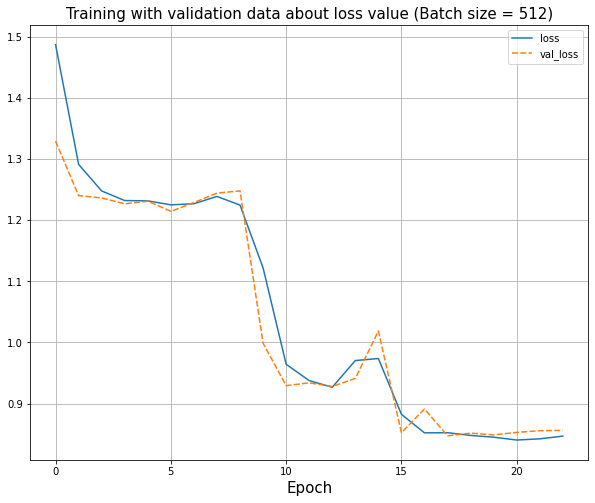

In [8]:
plt.figure(figsize=(10, 8))
sns.lineplot(data= pd.DataFrame(history.history)[['loss', 'val_loss']])
plt.grid(True)
plt.xlabel('Epoch', fontsize=15)
plt.title('Training with validation data about loss value (Batch size = 512)', fontsize=15)
plt.show()

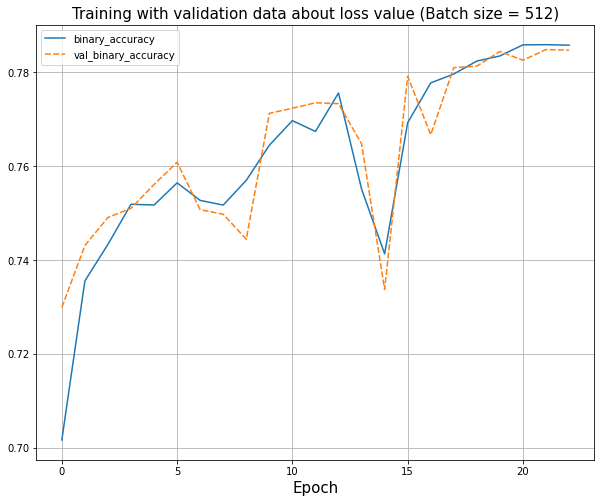

In [9]:
plt.figure(figsize=(10, 8))
sns.lineplot(data= pd.DataFrame(history.history)[['binary_accuracy', 'val_binary_accuracy']])
plt.grid(True)
plt.xlabel('Epoch', fontsize=15)
plt.title('Training with validation data about loss value (Batch size = 512)', fontsize=15)
plt.show()

In [10]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[1]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, :]
    return flattened_X

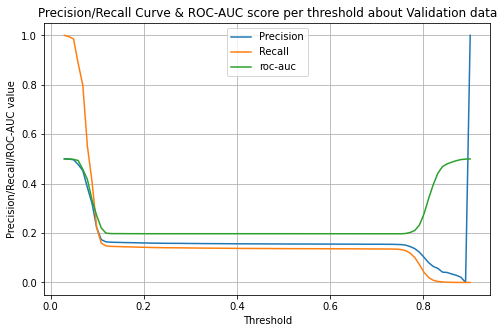

In [11]:
%matplotlib inline
val_preds = model.predict(x_val)
bin_acc = tf.metrics.binary_accuracy(flatten(x_val), flatten(val_preds))

result_df = pd.DataFrame({'Reconstruction_error':bin_acc, 
                         'True_class':list(y_val)})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(result_df['True_class'], result_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall/ROC-AUC value')
plt.title('Precision/Recall Curve & ROC-AUC score per threshold about Validation data')

auc = []
for thr in threshold_rt:
    pred_y = [1 if e >= thr else 0 for e in result_df.Reconstruction_error.values]  
    result_df['pred'] = pred_y
    auc.append(roc_auc_score(result_df.True_class, result_df['pred']))

plt.plot(threshold_rt, auc,label='roc-auc')
plt.legend(); plt.grid()
plt.show()


In [12]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt], end = ', ')

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.0 , recall:  0.0, threshold:  0.9009901


threshold: 0.9009901285171509
[[114485      0]
 [114485      0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67    114485
           1       0.00      0.00      0.00    114485

    accuracy                           0.50    228970
   macro avg       0.25      0.50      0.33    228970
weighted avg       0.25      0.50      0.33    228970

f1 score:  0.0
ROC-AUC: 0.5


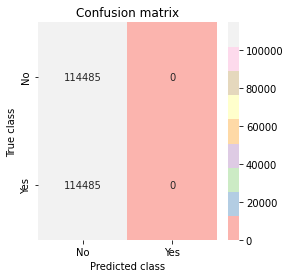

In [14]:
# for i in threshold_rt:
pred_y_val = [1 if e > threshold_fixed else 0 for e in result_df.Reconstruction_error.values]
cm = confusion_matrix(result_df.True_class, pred_y_val)
print(f'threshold: {threshold_fixed}')
print(cm)
print(classification_report(result_df.True_class, pred_y_val))
print("f1 score: ",f1_score(result_df['True_class'], pred_y_val))
print('ROC-AUC:', roc_auc_score(result_df.True_class, pred_y_val))

# confusion matrix heatmap
LABELS = ['No', 'Yes']
plt.figure(figsize=(4, 4)) 
sns.heatmap(cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="g", cmap='Pastel1'); plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 

In [15]:
loss, accuracy = model.evaluate(x_val, y_val)
print("테스트 데이터 정확도", accuracy)

7156/7156 [==============================] - 11s 2ms/step - loss: 0.8563 - binary_accuracy: 0.7848
테스트 데이터 정확도 0.7847616672515869


In [16]:
print("Validation data - Accuracy value: ",accuracy_score(result_df['True_class'], pred_y_val)) 

Validation data - Accuracy value:  0.5


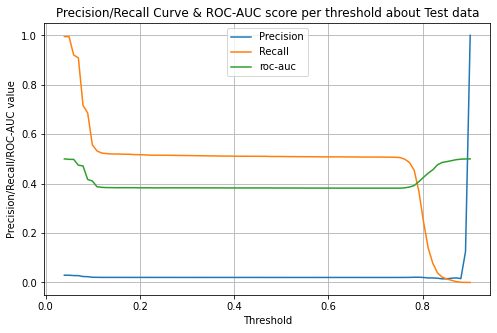

In [17]:
%matplotlib inline
preds = model.predict(X_test)
bin_acc = tf.metrics.binary_accuracy(flatten(X_test.values.reshape(-1, x_val.shape[1])), flatten(preds))

result_df = pd.DataFrame({'Reconstruction_error': bin_acc,
                         'True_class': y_test.tolist()})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(result_df['True_class'], result_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall/ROC-AUC value')
plt.title('Precision/Recall Curve & ROC-AUC score per threshold about Test data')

auc= []
for thr in threshold_rt:
    pred_y = [1 if e >= thr else 0 for e in result_df.Reconstruction_error.values]  
    result_df['pred'] = pred_y
    auc.append(roc_auc_score(result_df.True_class, result_df['pred']))

plt.plot(threshold_rt, auc,label='roc-auc')
plt.legend(); plt.grid()
plt.show()

In [18]:
# best position of threshold
# index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r]
print('precision: ',precision_rt[auc.index(np.max(auc))],', recall: ',recall_rt[auc.index(np.max(auc))], end = ', ')

# fixed Threshold
threshold_fixed = threshold_rt[auc.index(np.max(auc))]#threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.125 , recall:  0.0001348799568384138, threshold:  0.9009901


In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print("테스트 데이터 정확도", accuracy)

7899/7899 [==============================] - 17s 2ms/step - loss: 0.4759 - binary_accuracy: 0.7531
테스트 데이터 정확도 0.7531405687332153


In [20]:
pred_y = [1 if e >= threshold_fixed else 0 for e in result_df.Reconstruction_error.values]  
result_df['pred'] = pred_y
print("Test data - Accuracy value: ",accuracy_score(result_df['True_class'], result_df['pred'])) 

Test data - Accuracy value:  0.9706416500817049


threshold: 0.9009901285171509
[[245325      0]
 [  7414      0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    245325
           1       0.00      0.00      0.00      7414

    accuracy                           0.97    252739
   macro avg       0.49      0.50      0.49    252739
weighted avg       0.94      0.97      0.96    252739

f1 score:  0.0
ROC-AUC: 0.5


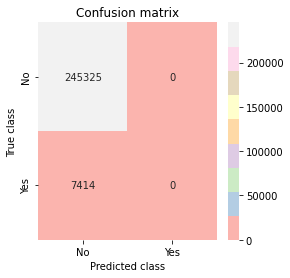

In [22]:
# for i in threshold_rt:
pred_y_test = [1 if e > threshold_fixed else 0 for e in result_df.Reconstruction_error.values]
cm = confusion_matrix(result_df.True_class, pred_y_test)
print(f'threshold: {threshold_fixed}')
print(cm)
print(classification_report(result_df.True_class, pred_y_test))
print("f1 score: ",f1_score(result_df['True_class'], pred_y_test))
print('ROC-AUC:', roc_auc_score(result_df.True_class, pred_y_test))

# confusion matrix heatmap
LABELS = ['No', 'Yes']
plt.figure(figsize=(4, 4)) 
sns.heatmap(cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="g", cmap='Pastel1'); plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 